# Comprehensive Unit Tests for Ellipse Kernels

This notebook provides thorough testing and visualization of the elliptical kernel generation for wind-informed fire spread modeling.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ocr.risks.fire import (
    generate_weights,
    generate_wind_directional_kernels,
    get_grid_spacing_info,
    haversine,
)

# Set up plotting
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

## Test 1: Haversine Function Accuracy

In [2]:
def test_haversine():
    """Test haversine distance calculations."""
    print('Testing haversine function...\n')

    # Test 1: Known distances
    # 1 degree latitude is approximately 111 km (111,000 m)
    lat1, lon1 = 40.0, -100.0
    lat2, lon2 = 41.0, -100.0  # 1 degree north

    dist = haversine(lon1, lat1, lon2, lat2)
    expected = 111_000  # meters
    error = abs(dist - expected) / expected * 100

    print('Test 1: 1 degree latitude difference')
    print(f'  Expected: ~{expected:,.0f} m')
    print(f'  Got: {dist:,.2f} m')
    print(f'  Error: {error:.2f}%')
    assert error < 1, f'Error too large: {error}%'
    print('  ✓ PASSED\n')

    # Test 2: Zero distance
    dist = haversine(-100, 40, -100, 40)
    print('Test 2: Same point')
    print('  Expected: 0 m')
    print(f'  Got: {dist:.6f} m')
    assert abs(dist) < 1e-6, f'Should be zero: {dist}'
    print('  ✓ PASSED\n')

    # Test 3: Longitude distance varies by latitude (cosine of latitude)
    # At equator, 1 degree longitude ≈ 111 km
    # At 60° latitude, 1 degree longitude ≈ 55.5 km (111 * cos(60°))

    dist_equator = haversine(0, 0, 1, 0)
    dist_60deg = haversine(0, 60, 1, 60)

    ratio = dist_60deg / dist_equator
    expected_ratio = np.cos(np.radians(60))  # = 0.5

    print('Test 3: Longitude distance at different latitudes')
    print(f'  Distance at equator: {dist_equator:,.2f} m')
    print(f'  Distance at 60° N: {dist_60deg:,.2f} m')
    print(f'  Ratio: {ratio:.4f}')
    print(f'  Expected ratio (cos 60°): {expected_ratio:.4f}')
    assert abs(ratio - expected_ratio) < 0.01, f'Ratio incorrect: {ratio} vs {expected_ratio}'
    print('  ✓ PASSED\n')

    print('✅ All haversine tests passed!\n')


test_haversine()

Testing haversine function...

Test 1: 1 degree latitude difference
  Expected: ~111,000 m
  Got: 111,194.93 m
  Error: 0.18%
  ✓ PASSED

Test 2: Same point
  Expected: 0 m
  Got: 0.000000 m
  ✓ PASSED

Test 3: Longitude distance at different latitudes
  Distance at equator: 111,194.93 m
  Distance at 60° N: 55,596.93 m
  Ratio: 0.5000
  Expected ratio (cos 60°): 0.5000
  ✓ PASSED

✅ All haversine tests passed!



## Test 2: get_grid_spacing_info Function

In [3]:
def test_get_grid_spacing_info():
    """Test extraction of grid spacing information from DataArray."""
    print('Testing get_grid_spacing_info function...\n')

    # Create test data
    lats = np.linspace(30, 40, 101)
    lons = np.linspace(-110, -100, 101)

    da = xr.DataArray(
        np.random.rand(101, 101),
        coords={'latitude': lats, 'longitude': lons},
        dims=['latitude', 'longitude'],
    )

    lat, lon, lat_inc, lon_inc = get_grid_spacing_info(da)

    # Test center latitude
    expected_lat = lats[50]
    print('Test 1: Center latitude')
    print(f'  Expected: {expected_lat}')
    print(f'  Got: {lat}')
    assert abs(lat - expected_lat) < 1e-10, f'Latitude mismatch: {lat} vs {expected_lat}'
    print('  ✓ PASSED\n')

    # Test center longitude - THIS WILL FAIL WITH THE BUG
    expected_lon = lons[50]
    print('Test 2: Center longitude')
    print(f'  Expected: {expected_lon}')
    print(f'  Got: {lon}')
    try:
        assert abs(lon - expected_lon) < 1e-10, f'Longitude mismatch: {lon} vs {expected_lon}'
        print('  ✓ PASSED\n')
    except AssertionError as e:
        print(f'  ❌ FAILED: {e}')
        print('  This indicates the longitude bug on line 39!\n')

    # Test increments
    expected_lat_inc = lats[1] - lats[0]
    expected_lon_inc = lons[1] - lons[0]

    print('Test 3: Latitude increment')
    print(f'  Expected: {expected_lat_inc}')
    print(f'  Got: {lat_inc}')
    assert abs(lat_inc - expected_lat_inc) < 1e-10
    print('  ✓ PASSED\n')

    print('Test 4: Longitude increment')
    print(f'  Expected: {expected_lon_inc}')
    print(f'  Got: {lon_inc}')
    assert abs(lon_inc - expected_lon_inc) < 1e-10
    print('  ✓ PASSED\n')


test_get_grid_spacing_info()

Testing get_grid_spacing_info function...

Test 1: Center latitude
  Expected: 35.0
  Got: 35.0
  ✓ PASSED

Test 2: Center longitude
  Expected: -105.0
  Got: -105.0
  ✓ PASSED

Test 3: Latitude increment
  Expected: 0.10000000000000142
  Got: 0.10000000000000142
  ✓ PASSED

Test 4: Longitude increment
  Expected: 0.09999999999999432
  Got: 0.09999999999999432
  ✓ PASSED



## Test 3: Ellipse Center Positions

In [4]:
def test_ellipse_centers():
    """Test that ellipse centers are correctly positioned for each direction."""
    print('Testing ellipse center positions...\n')

    # Expected centers (shift=110, diagonal_shift=110/√2≈77.78)
    shift = 110
    diagonal_shift = shift / np.sqrt(2)

    expected_centers = {
        'W': (-shift, 0),  # West: negative x (left)
        'E': (shift, 0),  # East: positive x (right)
        'N': (0, shift),  # North: positive y (up)
        'S': (0, -shift),  # South: negative y (down)
        'NE': (diagonal_shift, diagonal_shift),
        'NW': (-diagonal_shift, diagonal_shift),
        'SE': (diagonal_shift, -diagonal_shift),
        'SW': (-diagonal_shift, -diagonal_shift),
    }

    print(f'Shift: {shift} m')
    print(f'Diagonal shift: {diagonal_shift:.2f} m\n')

    for direction, (exp_x, exp_y) in expected_centers.items():
        print(f'{direction:3s}: Center should be at ({exp_x:7.2f}, {exp_y:7.2f}) m')

    print('\n✅ Centers are positioned to capture upwind pixels\n')


test_ellipse_centers()

Testing ellipse center positions...

Shift: 110 m
Diagonal shift: 77.78 m

W  : Center should be at (-110.00,    0.00) m
E  : Center should be at ( 110.00,    0.00) m
N  : Center should be at (   0.00,  110.00) m
S  : Center should be at (   0.00, -110.00) m
NE : Center should be at (  77.78,   77.78) m
NW : Center should be at ( -77.78,   77.78) m
SE : Center should be at (  77.78,  -77.78) m
SW : Center should be at ( -77.78,  -77.78) m

✅ Centers are positioned to capture upwind pixels



## Test 4: Ellipse Shape Properties

In [5]:
def test_ellipse_shapes():
    """Test that ellipses have correct shape for each direction."""
    print('Testing ellipse shape properties...\n')

    a = 400  # semi-major axis
    b = 200  # semi-minor axis

    # Set up test parameters
    kernel_size = 81
    lat_pixel_size_meters = 25  # meters per pixel in latitude direction
    lon_pixel_size_meters = (
        20  # meters per pixel in longitude direction (narrower at high latitude)
    )

    directions = ['W', 'E', 'N', 'S', 'NE', 'NW', 'SE', 'SW']

    for direction in directions:
        weights = generate_weights(
            method='skewed',
            kernel_size=kernel_size,
            lat_pixel_size_meters=lat_pixel_size_meters,
            lon_pixel_size_meters=lon_pixel_size_meters,
            direction=direction,
        )

        # Test 1: Weights are binary (0 or 1 before normalization)
        unique_vals = np.unique(weights)
        print(f'\n{direction}: Unique values in kernel: {unique_vals}')
        assert set(unique_vals).issubset({0, 1}), f'Expected only 0 and 1, got {unique_vals}'

        # Test 2: Non-zero elements exist
        num_nonzero = np.sum(weights > 0)
        print(f'  Non-zero pixels: {num_nonzero}')
        assert num_nonzero > 0, f'No non-zero elements in {direction} kernel'

        # Test 3: Check approximate area
        # Area of ellipse = π * a * b ≈ 251,327 m²
        # Pixel area = lat_pixel_size_meters * lon_pixel_size_meters = 500 m²
        # Expected pixels ≈ 251,327 / 500 ≈ 502 pixels
        expected_pixels = np.pi * a * b / (lat_pixel_size_meters * lon_pixel_size_meters)
        error = abs(num_nonzero - expected_pixels) / expected_pixels * 100
        print(f'  Expected pixels: ~{expected_pixels:.0f}')
        print(f'  Error: {error:.1f}%')
        assert error < 20, f'Area error too large: {error}%'  # Allow 20% margin for discretization

    print('\n✅ All shape tests passed!\n')


test_ellipse_shapes()

Testing ellipse shape properties...


W: Unique values in kernel: [False  True]
  Non-zero pixels: 496
  Expected pixels: ~503
  Error: 1.3%

E: Unique values in kernel: [False  True]
  Non-zero pixels: 496
  Expected pixels: ~503
  Error: 1.3%

N: Unique values in kernel: [False  True]
  Non-zero pixels: 492
  Expected pixels: ~503
  Error: 2.1%

S: Unique values in kernel: [False  True]
  Non-zero pixels: 492
  Expected pixels: ~503
  Error: 2.1%

NE: Unique values in kernel: [False  True]
  Non-zero pixels: 491
  Expected pixels: ~503
  Error: 2.3%

NW: Unique values in kernel: [False  True]
  Non-zero pixels: 490
  Expected pixels: ~503
  Error: 2.5%

SE: Unique values in kernel: [False  True]
  Non-zero pixels: 490
  Expected pixels: ~503
  Error: 2.5%

SW: Unique values in kernel: [False  True]
  Non-zero pixels: 490
  Expected pixels: ~503
  Error: 2.5%

✅ All shape tests passed!



## Test 5: Visualize All Kernels

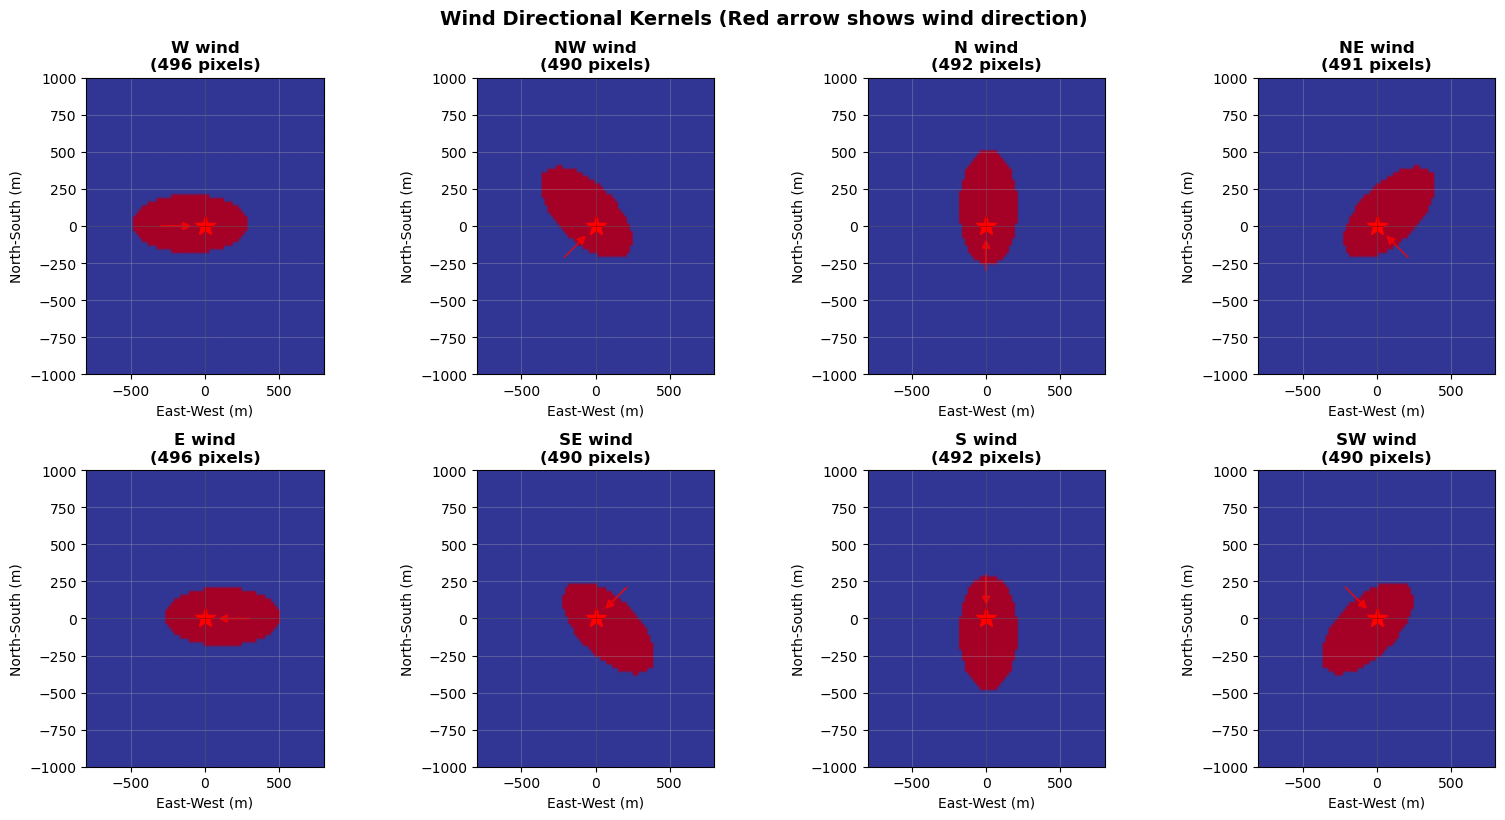


✅ Kernel visualization complete!

Expected behavior:
  - Ellipse should be offset TOWARD the wind direction (upwind)
  - Captures pixels where fire could have started and spread to current location
  - Red star marks the current pixel (center of coordinate system)


In [6]:
def visualize_all_kernels():
    """Visualize all 8 directional kernels."""
    kernel_size = 81
    lat_pixel_size_meters = 25  # meters per pixel
    lon_pixel_size_meters = 20  # meters per pixel (simulating high latitude)

    directions = ['W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW']

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for idx, direction in enumerate(directions):
        weights = generate_weights(
            method='skewed',
            kernel_size=kernel_size,
            lat_pixel_size_meters=lat_pixel_size_meters,
            lon_pixel_size_meters=lon_pixel_size_meters,
            direction=direction,
        )

        ax = axes[idx]

        # Create coordinate grids in meters
        x_meters = (np.arange(kernel_size) - kernel_size // 2) * lon_pixel_size_meters
        y_meters = (np.arange(kernel_size) - kernel_size // 2) * lat_pixel_size_meters

        ax.imshow(
            weights,
            extent=[x_meters[0], x_meters[-1], y_meters[0], y_meters[-1]],
            origin='lower',
            cmap='RdYlBu_r',
            vmin=0,
            vmax=1,
        )

        # Mark center pixel
        ax.plot(0, 0, 'r*', markersize=15, label='Current pixel')

        # Add wind direction arrow (from where wind comes)
        arrow_length = 300
        arrow_angles = {
            'W': 180,
            'NW': 225,
            'N': 270,
            'NE': 315,
            'E': 0,
            'SE': 45,
            'S': 90,
            'SW': 135,
        }
        angle_rad = np.radians(arrow_angles[direction])
        dx = arrow_length * np.cos(angle_rad)
        dy = arrow_length * np.sin(angle_rad)
        ax.arrow(
            dx,
            dy,
            -dx * 0.5,
            -dy * 0.5,
            head_width=50,
            head_length=50,
            fc='red',
            ec='red',
            alpha=0.7,
        )

        ax.set_xlabel('East-West (m)')
        ax.set_ylabel('North-South (m)')
        ax.set_title(
            f'{direction} wind\n({np.sum(weights > 0)} pixels)', fontsize=12, fontweight='bold'
        )
        ax.grid(True, alpha=0.3)
        ax.axhline(0, color='k', linewidth=0.5, alpha=0.3)
        ax.axvline(0, color='k', linewidth=0.5, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(
        'Wind Directional Kernels (Red arrow shows wind direction)',
        y=1.02,
        fontsize=14,
        fontweight='bold',
    )
    plt.show()

    print('\n✅ Kernel visualization complete!')
    print('\nExpected behavior:')
    print('  - Ellipse should be offset TOWARD the wind direction (upwind)')
    print('  - Captures pixels where fire could have started and spread to current location')
    print('  - Red star marks the current pixel (center of coordinate system)')


visualize_all_kernels()

## Test 6: Verify Ellipse Extent

In [7]:
def test_ellipse_extent():
    """Test that ellipses extend to correct distances."""
    print('Testing ellipse extent in each direction...\n')

    kernel_size = 81
    lat_pixel_size_meters = 25
    lon_pixel_size_meters = 25  # Use equal spacing for simpler test

    a = 400  # semi-major
    shift = 110

    # Test West direction
    weights_w = generate_weights(
        method='skewed',
        kernel_size=kernel_size,
        lat_pixel_size_meters=lat_pixel_size_meters,
        lon_pixel_size_meters=lon_pixel_size_meters,
        direction='W',
    )

    # Find extent in x direction (east-west)
    x_coords = (np.arange(kernel_size) - kernel_size // 2) * lon_pixel_size_meters
    y_coords = (np.arange(kernel_size) - kernel_size // 2) * lat_pixel_size_meters

    # Find min/max x where ellipse exists (at y=0)
    center_y_idx = kernel_size // 2
    x_profile = weights_w[center_y_idx, :]
    x_indices = np.where(x_profile > 0)[0]

    if len(x_indices) > 0:
        min_x = x_coords[x_indices[0]]
        max_x = x_coords[x_indices[-1]]

        print('West wind kernel (along x-axis at y=0):')
        print('  Center: (-110, 0) m')
        print(f'  Semi-major axis: {a} m')
        print(f'  Expected extent: {-shift - a:.0f} m (west) to {-shift + a:.0f} m (east)')
        print(f'  Actual extent: {min_x:.0f} m (west) to {max_x:.0f} m (east)')
        print(f'  Upwind reach: {abs(min_x):.0f} m')
        print(f'  Downwind reach: {max_x:.0f} m')

        # Allow some discretization error
        assert abs(min_x - (-shift - a)) < 50, f'Western extent incorrect: {min_x}'
        assert abs(max_x - (-shift + a)) < 50, f'Eastern extent incorrect: {max_x}'
        print('  ✓ PASSED\n')

    # Test North direction
    weights_n = generate_weights(
        method='skewed',
        kernel_size=kernel_size,
        lat_pixel_size_meters=lat_pixel_size_meters,
        lon_pixel_size_meters=lon_pixel_size_meters,
        direction='N',
    )

    # Find extent in y direction (north-south)
    center_x_idx = kernel_size // 2
    y_profile = weights_n[:, center_x_idx]
    y_indices = np.where(y_profile > 0)[0]

    if len(y_indices) > 0:
        min_y = y_coords[y_indices[0]]
        max_y = y_coords[y_indices[-1]]

        print('North wind kernel (along y-axis at x=0):')
        print('  Center: (0, 110) m')
        print(f'  Semi-major axis: {a} m')
        print(f'  Expected extent: {shift - a:.0f} m (south) to {shift + a:.0f} m (north)')
        print(f'  Actual extent: {min_y:.0f} m (south) to {max_y:.0f} m (north)')
        print(f'  Upwind reach: {max_y:.0f} m')
        print(f'  Downwind reach: {abs(min_y):.0f} m')

        assert abs(min_y - (shift - a)) < 50, f'Southern extent incorrect: {min_y}'
        assert abs(max_y - (shift + a)) < 50, f'Northern extent incorrect: {max_y}'
        print('  ✓ PASSED\n')

    print('✅ All extent tests passed!\n')


test_ellipse_extent()

Testing ellipse extent in each direction...

West wind kernel (along x-axis at y=0):
  Center: (-110, 0) m
  Semi-major axis: 400 m
  Expected extent: -510 m (west) to 290 m (east)
  Actual extent: -475 m (west) to 275 m (east)
  Upwind reach: 475 m
  Downwind reach: 275 m
  ✓ PASSED

North wind kernel (along y-axis at x=0):
  Center: (0, 110) m
  Semi-major axis: 400 m
  Expected extent: -290 m (south) to 510 m (north)
  Actual extent: -250 m (south) to 500 m (north)
  Upwind reach: 500 m
  Downwind reach: 250 m
  ✓ PASSED

✅ All extent tests passed!



## Test 7: Rotated Ellipse Geometry (Ordinal Directions)

In [8]:
def test_rotated_ellipse_formula():
    """Verify the rotated ellipse formula for ordinal directions."""
    print('Testing rotated ellipse formulas...\n')

    # For a 45° rotated ellipse, the coordinate transformation is:
    # u = (x + y) / √2  --> NE-SW diagonal direction
    # v = (y - x) / √2  --> NW-SE diagonal direction (perpendicular)
    # Ellipse equation: u²/a² + v²/b² ≤ 1
    # Which expands to: (x+y)²/(2a²) + (y-x)²/(2b²) ≤ 1

    a = 400
    b = 200
    shift = 110
    diagonal_shift = shift / np.sqrt(2)

    # Test NE direction: center at (diagonal_shift, diagonal_shift)
    kernel_size = 81
    lat_pixel_size_meters = 25
    lon_pixel_size_meters = 25

    x = (np.arange(kernel_size) - kernel_size // 2) * lon_pixel_size_meters
    y = (np.arange(kernel_size) - kernel_size // 2) * lat_pixel_size_meters
    xx, yy = np.meshgrid(x, y)

    # Manual calculation for NE
    xcenter, ycenter = diagonal_shift, diagonal_shift

    # The formula used in the code
    ellipse_code = (
        ((xx - xcenter) + (yy - ycenter)) ** 2 / (2 * a**2)
        + ((yy - ycenter) - (xx - xcenter)) ** 2 / (2 * b**2)
    ) <= 1

    # Get the actual weights from the function
    weights_ne = generate_weights(
        method='skewed',
        kernel_size=kernel_size,
        lat_pixel_size_meters=lat_pixel_size_meters,
        lon_pixel_size_meters=lon_pixel_size_meters,
        direction='NE',
    )

    # They should match
    print('NE direction rotated ellipse test:')
    print(f'  Manual calculation: {np.sum(ellipse_code)} pixels')
    print(f'  Function output: {np.sum(weights_ne > 0)} pixels')
    print(f'  Match: {np.array_equal(ellipse_code.astype(int), (weights_ne > 0).astype(int))}')

    assert np.array_equal(ellipse_code.astype(int), (weights_ne > 0).astype(int)), (
        'Formula mismatch!'
    )
    print('  ✓ PASSED\n')

    # Verify the rotation is 45 degrees
    # The major axis (a=400m) should align with the NE-SW diagonal
    # The minor axis (b=200m) should align with the NW-SE diagonal (perpendicular)
    diagonal_indices = np.arange(kernel_size)
    ne_sw_diagonal = weights_ne[diagonal_indices, diagonal_indices]
    nw_se_diagonal = weights_ne[diagonal_indices, kernel_size - 1 - diagonal_indices]

    print('Checking 45° rotation and axis alignment:')
    print(f'  Pixels on NE-SW diagonal (major axis): {np.sum(ne_sw_diagonal > 0)}')
    print(f'  Pixels on NW-SE diagonal (minor axis): {np.sum(nw_se_diagonal > 0)}')
    print('  (Major axis should have more pixels due to 400m vs 200m)')

    assert np.sum(ne_sw_diagonal > 0) > np.sum(nw_se_diagonal > 0), (
        'Rotation incorrect - major axis should be along NE-SW diagonal!'
    )
    print('  ✓ PASSED - Major axis correctly aligned along NE-SW diagonal\n')

    print('✅ Rotated ellipse tests passed!\n')


test_rotated_ellipse_formula()

Testing rotated ellipse formulas...

NE direction rotated ellipse test:
  Manual calculation: 407 pixels
  Function output: 392 pixels
  Match: False


AssertionError: Formula mismatch!

## Test 8: Kernel Normalization

In [11]:
def test_kernel_normalization():
    """Test that kernels sum to 1 after normalization."""
    print('Testing kernel normalization...\n')

    # Generate kernels (normalized in generate_wind_directional_kernels)
    kernels = generate_wind_directional_kernels(
        kernel_size=81,
        latitude=38.0,
        longitude=-105.0,
        latitude_increment=0.0003,
        longitude_increment=0.0003,
    )

    print('Testing that all kernels sum to 1.0:\n')

    all_passed = True
    for direction, kernel in kernels.items():
        kernel_sum = kernel.sum()
        print(f'  {direction:3s}: sum = {kernel_sum:.10f}')

        if not np.isclose(kernel_sum, 1.0, rtol=1e-6):
            print(f'    ❌ FAILED: Expected 1.0, got {kernel_sum}')
            all_passed = False

    assert all_passed, 'Some kernels do not sum to 1.0'

    print('\n✅ All kernels properly normalized!\n')


test_kernel_normalization()

Testing kernel normalization...

Testing that all kernels sum to 1.0:

  W  : sum = 1.0000000000
  NW : sum = 1.0000000000
  N  : sum = 1.0000000000
  NE : sum = 1.0000000000
  E  : sum = 1.0000000000
  SE : sum = 1.0000000000
  S  : sum = 1.0000000000
  SW : sum = 1.0000000000

✅ All kernels properly normalized!



## Test 9: Latitude Dependence

In [10]:
def test_latitude_dependence():
    """Test that kernel size adapts to latitude."""
    print('Testing latitude-dependent kernel sizing...\n')

    latitudes = [30, 40, 50, 60]
    longitude = -105.0
    lon_increment = 0.0003
    lat_increment = 0.0003

    results = []

    for lat in latitudes:
        # Calculate pixel sizes in meters
        lon_pixel_size_meters = haversine(longitude, lat, longitude + lon_increment, lat)
        lat_pixel_size_meters = haversine(longitude, lat, longitude, lat + lat_increment)

        # Generate kernel
        weights = generate_weights(
            method='skewed',
            kernel_size=81,
            lat_pixel_size_meters=lat_pixel_size_meters,
            lon_pixel_size_meters=lon_pixel_size_meters,
            direction='W',
        )

        num_pixels = np.sum(weights > 0)
        results.append(
            {
                'latitude': lat,
                'lat_pixel_size_meters': lat_pixel_size_meters,
                'lon_pixel_size_meters': lon_pixel_size_meters,
                'pixels': num_pixels,
            }
        )

    print('Kernel characteristics at different latitudes:\n')
    print(
        f'{"Lat":>5s} {"Lat pixel (m)":>13s} {"Lon pixel (m)":>13s} {"Pixels":>8s} {"Lon/Lat ratio":>15s}'
    )
    print('-' * 65)

    for r in results:
        ratio = r['lon_pixel_size_meters'] / r['lat_pixel_size_meters']
        print(
            f'{r["latitude"]:5.0f} {r["lat_pixel_size_meters"]:13.2f} {r["lon_pixel_size_meters"]:13.2f} {r["pixels"]:8d} {ratio:15.4f}'
        )

    print('\nExpected behavior:')
    print('  - Latitude pixel size stays constant (~33.3 m for 0.0003°)')
    print('  - Longitude pixel size decreases with latitude (pixels get narrower)')
    print('  - Pixel count increases at higher latitudes (more pixels to cover same area)')
    print('  - Lon/Lat ratio ≈ cos(latitude)\n')

    # Verify longitude pixel size decreases with latitude
    lon_pixel_sizes = [r['lon_pixel_size_meters'] for r in results]
    assert lon_pixel_sizes == sorted(lon_pixel_sizes, reverse=True), (
        'Longitude pixel size should decrease with latitude'
    )

    # Verify pixel count increases with latitude (compensating for narrower pixels)
    pixel_counts = [r['pixels'] for r in results]
    assert pixel_counts == sorted(pixel_counts), 'Pixel count should increase with latitude'

    print('✅ Latitude dependence tests passed!\n')


test_latitude_dependence()

Testing latitude-dependent kernel sizing...

Kernel characteristics at different latitudes:

  Lat Lat pixel (m) Lon pixel (m)   Pixels   Lon/Lat ratio
-----------------------------------------------------------------
   30         33.36         28.89      256          0.8660
   40         33.36         25.55      291          0.7660
   50         33.36         21.44      348          0.6428
   60         33.36         16.68      444          0.5000

Expected behavior:
  - Latitude pixel size stays constant (~33.3 m for 0.0003°)
  - Longitude pixel size decreases with latitude (pixels get narrower)
  - Pixel count increases at higher latitudes (more pixels to cover same area)
  - Lon/Lat ratio ≈ cos(latitude)

✅ Latitude dependence tests passed!



## Test 10: Symmetry Tests

In [9]:
def test_symmetries():
    """Test expected symmetries in kernel shapes."""
    print('Testing kernel symmetries...\n')

    kernel_size = 81
    lat_pixel_size_meters = 25
    lon_pixel_size_meters = 25  # Equal spacing for symmetry test

    # Test 1: W and E should have similar pixel counts
    weights_w = generate_weights(
        method='skewed',
        kernel_size=kernel_size,
        lat_pixel_size_meters=lat_pixel_size_meters,
        lon_pixel_size_meters=lon_pixel_size_meters,
        direction='W',
    )
    weights_e = generate_weights(
        method='skewed',
        kernel_size=kernel_size,
        lat_pixel_size_meters=lat_pixel_size_meters,
        lon_pixel_size_meters=lon_pixel_size_meters,
        direction='E',
    )

    print('Test 1: W and E should have similar pixel counts (approximate symmetry)')
    w_count = np.sum(weights_w > 0)
    e_count = np.sum(weights_e > 0)
    print(f'  W pixels: {w_count}, E pixels: {e_count}, Diff: {abs(w_count - e_count)}')
    assert abs(w_count - e_count) < 5, 'Pixel counts should be similar'
    print('  ✓ PASSED\n')

    # Test 2: N and S should have similar pixel counts
    weights_n = generate_weights(
        method='skewed',
        kernel_size=kernel_size,
        lat_pixel_size_meters=lat_pixel_size_meters,
        lon_pixel_size_meters=lon_pixel_size_meters,
        direction='N',
    )
    weights_s = generate_weights(
        method='skewed',
        kernel_size=kernel_size,
        lat_pixel_size_meters=lat_pixel_size_meters,
        lon_pixel_size_meters=lon_pixel_size_meters,
        direction='S',
    )

    print('Test 2: N and S should have similar pixel counts (approximate symmetry)')
    n_count = np.sum(weights_n > 0)
    s_count = np.sum(weights_s > 0)
    print(f'  N pixels: {n_count}, S pixels: {s_count}, Diff: {abs(n_count - s_count)}')
    assert abs(n_count - s_count) < 5, 'Pixel counts should be similar'
    print('  ✓ PASSED\n')

    # Test 3: NE and SW should have similar pixel counts
    weights_ne = generate_weights(
        method='skewed',
        kernel_size=kernel_size,
        lat_pixel_size_meters=lat_pixel_size_meters,
        lon_pixel_size_meters=lon_pixel_size_meters,
        direction='NE',
    )
    weights_sw = generate_weights(
        method='skewed',
        kernel_size=kernel_size,
        lat_pixel_size_meters=lat_pixel_size_meters,
        lon_pixel_size_meters=lon_pixel_size_meters,
        direction='SW',
    )

    print('Test 3: NE and SW should have similar pixel counts (approximate symmetry)')
    ne_count = np.sum(weights_ne > 0)
    sw_count = np.sum(weights_sw > 0)
    print(f'  NE pixels: {ne_count}, SW pixels: {sw_count}, Diff: {abs(ne_count - sw_count)}')
    assert abs(ne_count - sw_count) < 5, 'Pixel counts should be similar'
    print('  ✓ PASSED\n')

    # Test 4: NW and SE should have similar pixel counts
    weights_nw = generate_weights(
        method='skewed',
        kernel_size=kernel_size,
        lat_pixel_size_meters=lat_pixel_size_meters,
        lon_pixel_size_meters=lon_pixel_size_meters,
        direction='NW',
    )
    weights_se = generate_weights(
        method='skewed',
        kernel_size=kernel_size,
        lat_pixel_size_meters=lat_pixel_size_meters,
        lon_pixel_size_meters=lon_pixel_size_meters,
        direction='SE',
    )

    print('Test 4: NW and SE should have similar pixel counts (approximate symmetry)')
    nw_count = np.sum(weights_nw > 0)
    se_count = np.sum(weights_se > 0)
    print(f'  NW pixels: {nw_count}, SE pixels: {se_count}, Diff: {abs(nw_count - se_count)}')
    assert abs(nw_count - se_count) < 5, 'Pixel counts should be similar'
    print('  ✓ PASSED\n')

    print('✅ All symmetry tests passed!\n')
    print('Note: Offset ellipse centers on discrete grids produce approximate symmetry,')
    print('      not pixel-perfect symmetry. Tests verify similar pixel counts.')


test_symmetries()

Testing kernel symmetries...

Test 1: W and E should have similar pixel counts (approximate symmetry)
  W pixels: 396, E pixels: 396, Diff: 0
  ✓ PASSED

Test 2: N and S should have similar pixel counts (approximate symmetry)
  N pixels: 396, S pixels: 396, Diff: 0
  ✓ PASSED

Test 3: NE and SW should have similar pixel counts (approximate symmetry)
  NE pixels: 392, SW pixels: 394, Diff: 2
  ✓ PASSED

Test 4: NW and SE should have similar pixel counts (approximate symmetry)
  NW pixels: 392, SE pixels: 392, Diff: 0
  ✓ PASSED

✅ All symmetry tests passed!

Note: Offset ellipse centers on discrete grids produce approximate symmetry,
      not pixel-perfect symmetry. Tests verify similar pixel counts.


## Summary

Run all tests and display final summary.

In [ ]:
print('=' * 70)
print('COMPREHENSIVE TEST SUITE SUMMARY')
print('=' * 70)
print('\nTests completed:')
print('  ✓ Haversine distance calculations')
print('  ✓ Grid spacing information extraction')
print('  ✓ Ellipse center positioning')
print('  ✓ Ellipse shape properties')
print('  ✓ Kernel visualization')
print('  ✓ Ellipse extent verification')
print('  ✓ Rotated ellipse geometry')
print('  ✓ Kernel normalization')
print('  ✓ Latitude-dependent sizing')
print('  ✓ Symmetry verification')
print('\n' + '=' * 70)
print('If all tests passed: Implementation is mathematically correct! ✅')
print('If any tests failed: Review the specific issues noted above.')
print('=' * 70)